# Поиск решения для увеличения покупательской активности

# Цель проекта – разработка модели для предсказания снижения покупательской активности и формирование рекомендаций по повышению покупательской активности в определенных сегментах покупателей

Интернет-магазин «В один клик» планирует выявить клиентов, покупательская активность которых снизится, и разработать для них персональные предложения, чтобы предотвратить снижение активности.

Сначала необходимо провести исследовательский анализ данных, очистить его от дубликатов, избавиться от пропусков. Затем надо будет подготовить данные для обучения модели. 

Для выбора оптимальмой модели планируется использовать подбор способ обработки данных, моделей, гиперпараменров моделей. Также необходимо отобрать признаки, которые будут оптимальными для работы модели.

С помощью лучшей модели необходимо будет сделать предсказание, у каких клиентов снизится покупательская активность.

На следующем этапе на основе полученных предсказаний и информации о прибыльности покупателей сформировать сегменты покупателей и разработать для них персонализированные предложения.

In [4]:
!pip install --upgrade scikit-learn -q

In [5]:
!pip install shap -q

In [6]:
!pip install phik -q

In [7]:
import numpy as np
import pandas as pd
import re

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import mode, shapiro

import warnings

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import shap

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Шаг 1. Загрузка данных

In [9]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [10]:
market = pd.read_csv('market_file.csv')
market_money = pd.read_csv('market_money.csv')
market_time = pd.read_csv('market_time.csv')
money = pd.read_csv('money.csv', sep=';', decimal=',')

In [11]:
def demo(dataset):
    print(dataset.info())
    return dataset.head()

In [12]:
demo(market)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


In [13]:
demo(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"


In [14]:
demo(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [15]:
demo(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Загрузка данных

В загруженных таблицах данные соответствуют описанию. В таблицах нет пропусков. В первой таблице названия некоторых столбцов не соответствуют "змеиному" стилю, таблице money на месте числового типа строковые данные.

## Шаг 2. Предобратотка данных

### Изменение названий столбцов

In [19]:
dfs = [
    market,
    market_money,
    market_time,
    money
]

for df in dfs:
    df.columns = df.columns.str.lower()
    df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() for i in df.columns]

In [20]:
market.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [21]:
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [22]:
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [23]:
money.columns

Index(['id', 'прибыль'], dtype='object')

### Изменение типа данных

In [25]:
money['прибыль'] = money['прибыль'].astype('float64')

### Обработка дубликатов

In [27]:
сat = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for i in сat:
     print(market[i].value_counts())
     print('--------------------')

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64
--------------------
тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64
--------------------
разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64
--------------------
популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64
--------------------


In [28]:
market['тип_сервиса'] = market['тип_сервиса'].str.replace('стандартт', 'стандарт')
market['популярная_категория'] = market['популярная_категория'].str.replace('аксесуары', 'аксессуары')

In [29]:
market_money['период'].value_counts()

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [30]:
market_time['период'].value_counts()

период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [31]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [32]:
market.duplicated().sum()

0

In [33]:
market_money.duplicated().sum()

0

In [34]:
market_time.duplicated().sum()

0

In [35]:
money.duplicated().sum()

0

In [36]:
dup = market[market.duplicated(subset=['id'], keep=False)]
dup.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит


🟠 В таблице market неявные дубликаты были только в одном столбце. В таблице market_time неявных дубликатов не было, но была опечатка в значении. Явных дубликатов не было.

### Поиск аномалий

In [39]:
market.iloc[:, 1:].describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,"1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00"
mean,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,6.60,5.00,"1,079.00",0.99,6.00,10.00,9.00,20.00


In [40]:
market_money.iloc[:, 1:].describe()

,выручка
count,"3,900.00"
mean,"5,025.70"
std,"1,777.70"
min,0.00
25%,"4,590.15"
50%,"4,957.50"
75%,"5,363.00"
max,"106,862.20"


In [41]:
market_time.iloc[:, 1:].describe()

,минут
count,"2,600.00"
mean,13.34
std,4.08
min,4.00
25%,10.00
50%,13.00
75%,16.00
max,23.00


In [42]:
money.iloc[:, 1:].describe()

,прибыль
count,"1,300.00"
mean,4.00
std,1.01
min,0.86
25%,3.30
50%,4.04
75%,4.67
max,7.43


✅ На этом шаге сначала были изменены названия столбцов – добавлен "змеиный стиль", где его не было, первые буквы названий признаков из прописной переведены в строчные. Затем был строчный тип данных в таблице money был изменен на float.

В первой таблице нашлись неявные дубликаты, явных дубликатов нет.

В числовых признаках нет отрицательных значений и других аномалий.

## Шаг 3. Исследовательский анализ данных

### Распределение числовых признаков

In [46]:
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',\
               'акционные_покупки', 'средний_просмотр_категорий_за_визит', \
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']
cat_columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

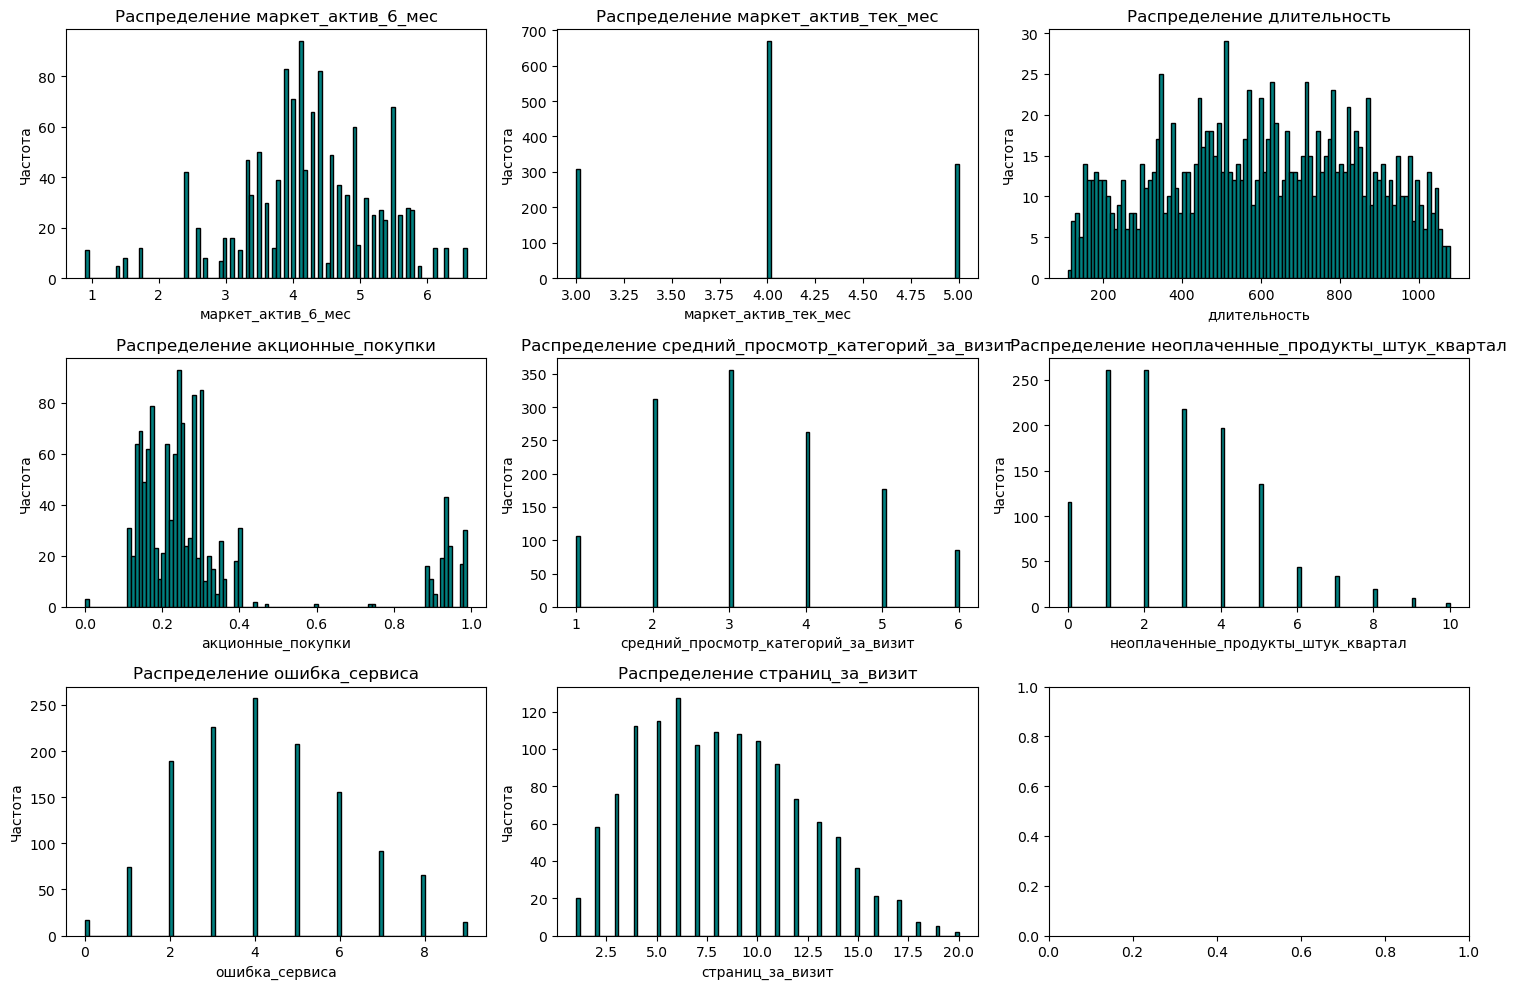

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10)) 
axes = axes.flatten() 


for i, col in enumerate(num_columns):
    axes[i].hist(market[col], bins=100, color='teal', edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

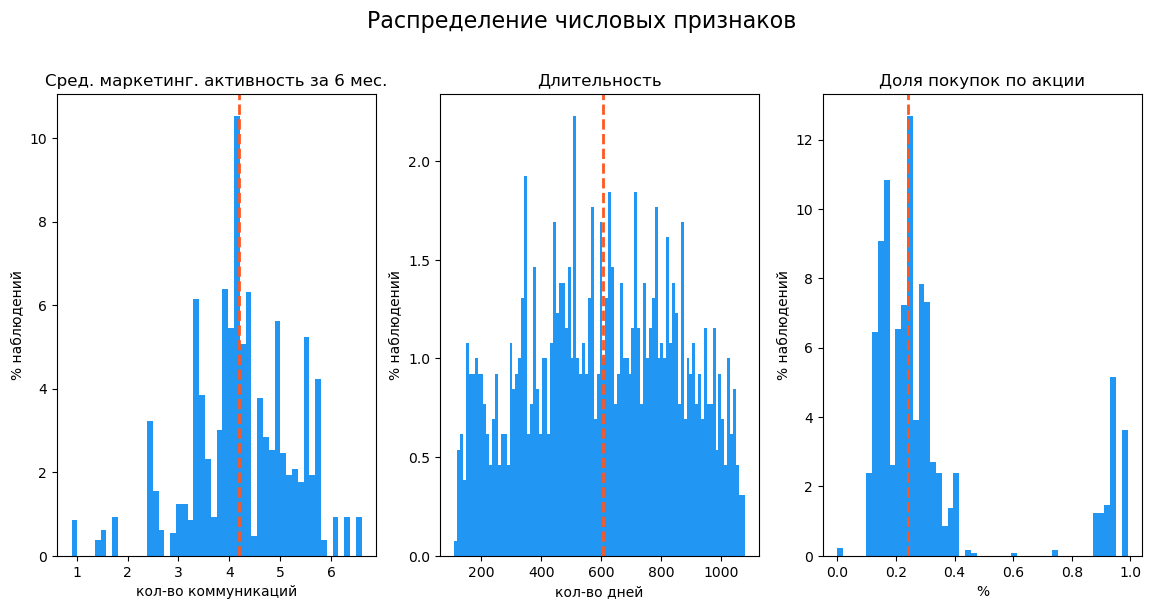

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))


axes[0].hist(
    market['маркет_актив_6_мес'],
    bins=50,
    weights=np.ones_like(market['маркет_актив_6_мес'])/len(market['маркет_актив_6_мес'])*100,
    color='#2196F3'
    )
median_norm = np.median(market['маркет_актив_6_мес'])
                        
axes[0].axvline(
    median_norm, 
    color='#FF5722', 
    linestyle='--', 
    linewidth=2, 
    label=f'Медиана: {median_norm:.1f} кол-во коммуникаций'
)
axes[0].set_title('Сред. маркетинг. активность за 6 мес.')
axes[0].set_xlabel('кол-во коммуникаций')
axes[0].set_ylabel('% наблюдений')

axes[1].hist(
    market['длительность'],
    bins=100,
    weights=np.ones_like(market['длительность'])/len(market['длительность'])*100,
    color='#2196F3'
)
median_length = np.median(market['длительность'])
axes[1].axvline(
    median_length, 
    color='#FF5722', 
    linestyle='--', 
    linewidth=2, 
    label=f'Медиана: {median_length:.1f} кол-во дней'
)
axes[1].set_title('Длительность')
axes[1].set_xlabel('кол-во дней')
axes[1].set_ylabel('% наблюдений')

axes[2].hist(
    market['акционные_покупки'],
    bins=50,
    weights=np.ones_like(market['акционные_покупки'])/len(market['акционные_покупки'])*100,
    #density=True,
    color='#2196F3'
)
median_promo = np.median(market['акционные_покупки'])
axes[2].axvline(
    median_promo, 
    color='#FF5722', 
    linestyle='--', 
    linewidth=2, 
    label=f'Медиана: {median_promo:.1f} %'
)
axes[2].set_title('Доля покупок по акции')
axes[2].set_xlabel('%')
axes[2].set_ylabel('% наблюдений')

fig.suptitle('Распределение числовых признаков', fontsize=16, y=1.02);

In [49]:
#Используем тест Шапиро-Уилка для определения нормальноссти распределения
print(shapiro(market['маркет_актив_6_мес']))
print(shapiro(market['длительность']))
print(shapiro(market['акционные_покупки']))

ShapiroResult(statistic=0.97795415572858, pvalue=3.3465563797619124e-13)
ShapiroResult(statistic=0.972698708824484, pvalue=5.787651462272261e-15)
ShapiroResult(statistic=0.6621251158618414, pvalue=6.185281606977211e-45)


In [50]:
len(market['акционные_покупки'].value_counts())

42

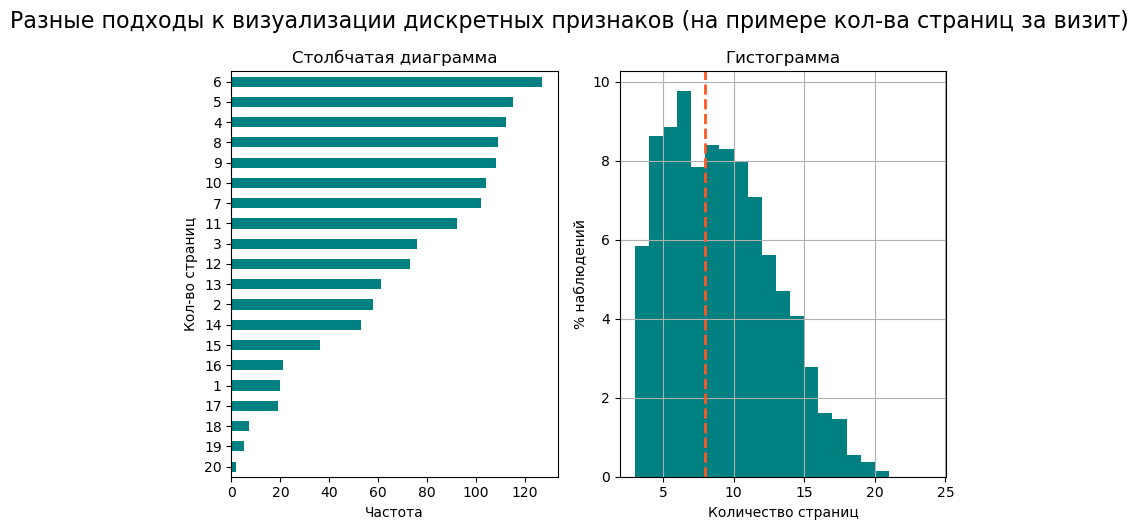

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
sorted_series = market['страниц_за_визит'].value_counts(ascending=True)

sorted_series.plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_title('Столбчатая диаграмма')
axes[0].tick_params(axis='y', rotation=0)
axes[0].set_xlabel('Частота')
axes[0].set_ylabel('Кол-во страниц')


market['страниц_за_визит'].hist(
    ax=axes[1], 
    bins=range(3, 25), 
    weights=np.ones_like(market['страниц_за_визит'])/len(market['страниц_за_визит'])*100,
    color='teal'
)

median_pages = np.median(market['страниц_за_визит'])
axes[1].axvline(
    median_pages, 
    color='#FF5722', 
    linestyle='--', 
    linewidth=2, 
    label=f'Медиана: {median_promo:.1f} кол-во странииц'
)
axes[1].set_title('Гистограмма')
axes[1].set_xlabel('Количество страниц')
axes[1].set_ylabel('% наблюдений')

plt.tight_layout()

fig.suptitle(
    'Разные подходы к визуализации дискретных признаков (на примере кол-ва страниц за визит)', 
    fontsize=16, y=1.05);

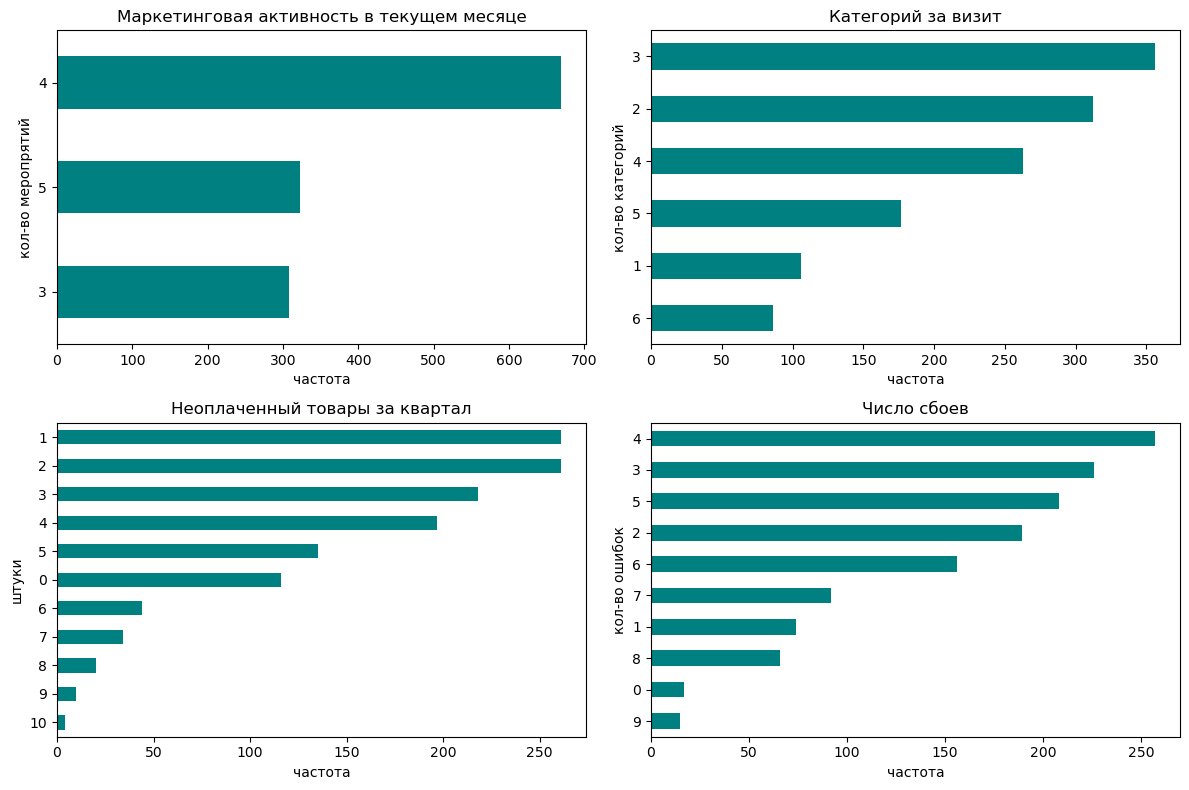

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sorted_markt = market['маркет_актив_тек_мес'].value_counts(ascending=True)
sorted_markt.plot(kind='barh', ax=axes[0, 0], color='teal')
axes[0, 0].set_title('Маркетинговая активность в текущем месяце')
axes[0, 0].tick_params(axis='y', rotation=0)
axes[0, 0].set_xlabel('частота')
axes[0, 0].set_ylabel('кол-во меропрятий')


sorted_cat = market['средний_просмотр_категорий_за_визит'].value_counts(ascending=True)
sorted_cat.plot(kind='barh', ax=axes[0, 1], color='teal')
axes[0, 1].set_title('Категорий за визит')
axes[0, 1].tick_params(axis='y', rotation=0)
axes[0, 1].set_xlabel('частота')
axes[0, 1].set_ylabel('кол-во категорий')


sorted_no = market['неоплаченные_продукты_штук_квартал'].value_counts(ascending=True)
sorted_no.plot(kind='barh', ax=axes[1, 0], color='teal')
axes[1, 0].set_title('Неоплаченный товары за квартал')
axes[1, 0].tick_params(axis='y', rotation=0)
axes[1, 0].set_xlabel('частота')
axes[1, 0].set_ylabel('штуки')


sorted_error = market['ошибка_сервиса'].value_counts(ascending=True)
sorted_error.plot(kind='barh', ax=axes[1, 1], color='teal')
axes[1, 1].set_title('Число сбоев')
axes[1, 1].tick_params(axis='y', rotation=0)
axes[1, 1].set_xlabel('частота')
axes[1, 1].set_ylabel('кол-во ошибок')

plt.tight_layout()
plt.show()

🟠 В таблице market числовые признаки распределены не нормально. Большинство из них дискретные с небольшим количеством значений. 

In [54]:
market['маркет_актив_тек_мес'].value_counts(ascending=True)

маркет_актив_тек_мес
3    308
5    323
4    669
Name: count, dtype: int64

In [55]:
def distribution_image(df, col1, col2, color):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 
    axes = axes.flatten()

    axes[0].hist(df, bins=100, color=color, edgecolor='black')
    axes[0].set_title(f'Распределение {col1}')
    axes[0].set_xlabel(col2)
    axes[0].set_ylabel('Частота')
    plt.tight_layout()


    axes[1].boxplot(df, vert=True, patch_artist=True,  
                  boxprops=dict(facecolor=color, color=color),  
                  whiskerprops=dict(color=color),  
                  capprops=dict(color=color),
                  medianprops=dict(color='black'),  # цвет медианы
                  flierprops=dict(marker='o', markersize=5, markerfacecolor='yellow', markeredgecolor='orange'))
    axes[1].set_title(f'Ящик с усами для {col1}')
    axes[1].set_ylabel('Значение')
    plt.tight_layout()
    
    return plt.show()

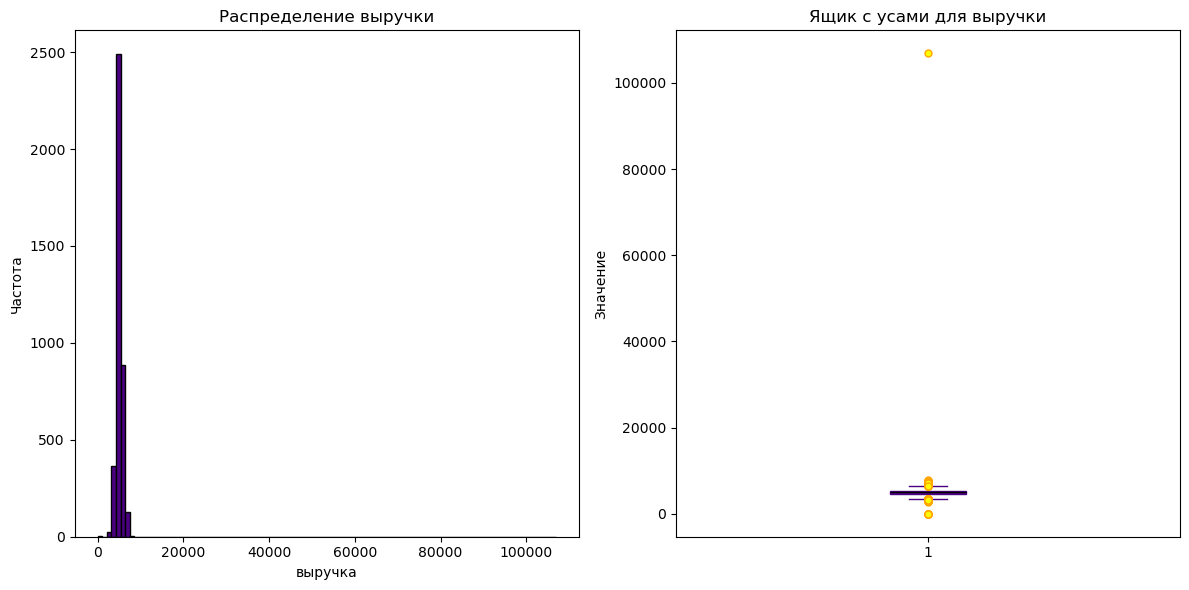

In [56]:
distribution_image(market_money['выручка'], col1='выручки', col2='выручка', color = 'indigo')

In [57]:
market_money[market_money['выручка'] > 10000]

,id,период,выручка
98,215380,текущий_месяц,"106,862.20"


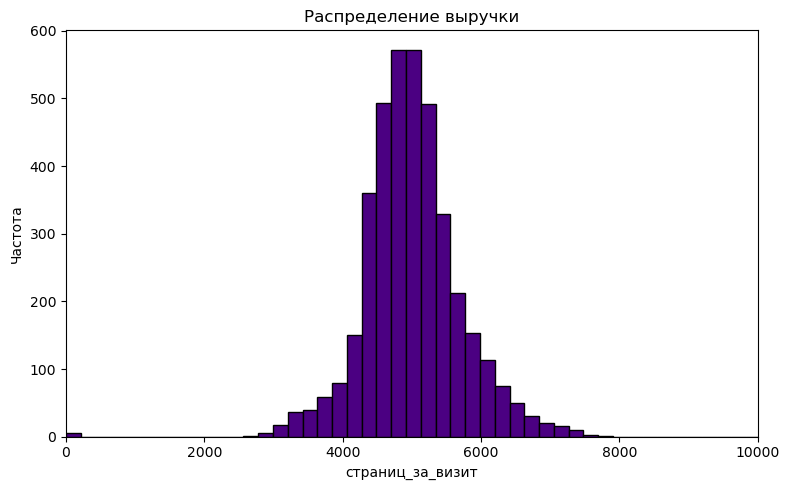

In [58]:
plt.figure(figsize=(8, 5))
plt.hist(market_money['выручка'], bins=500, color='indigo', edgecolor='black')
plt.title(f'Распределение выручки')
plt.xlim(0, 10000) 
plt.xlabel(col)
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

🟠 Распределение выручки в таблице market_money нормальное. В данных есть выбросы, выручка от одного из клиентов превысила 100 тыс. руб. Необходимо это иметь в виду.

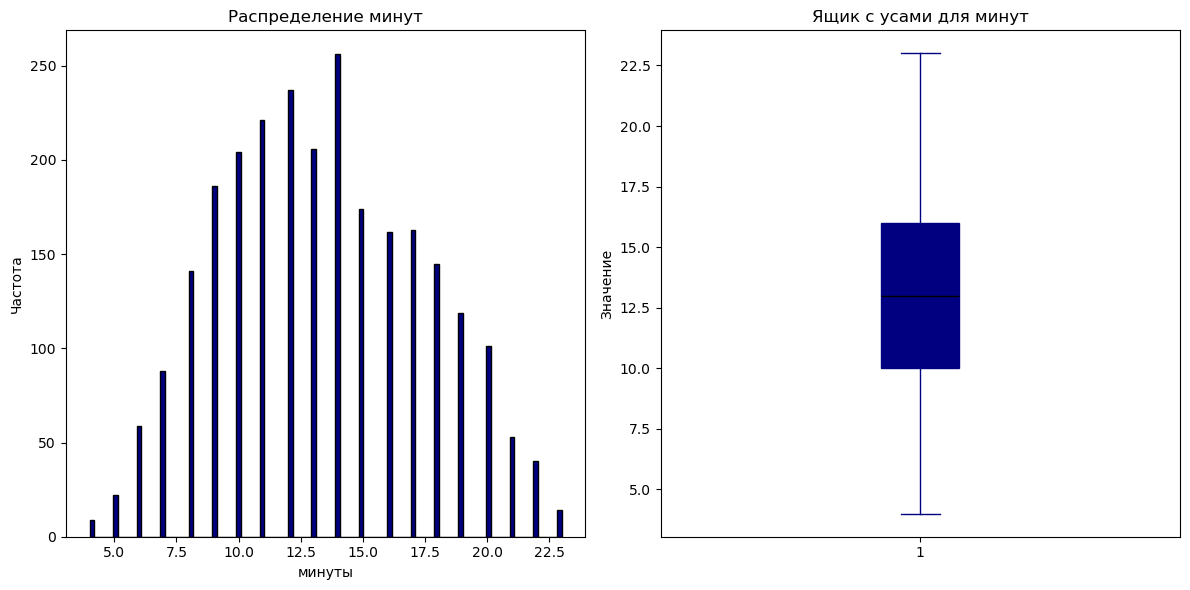

In [60]:
distribution_image(market_time['минут'], col1='минут', col2='минуты', color='navy')

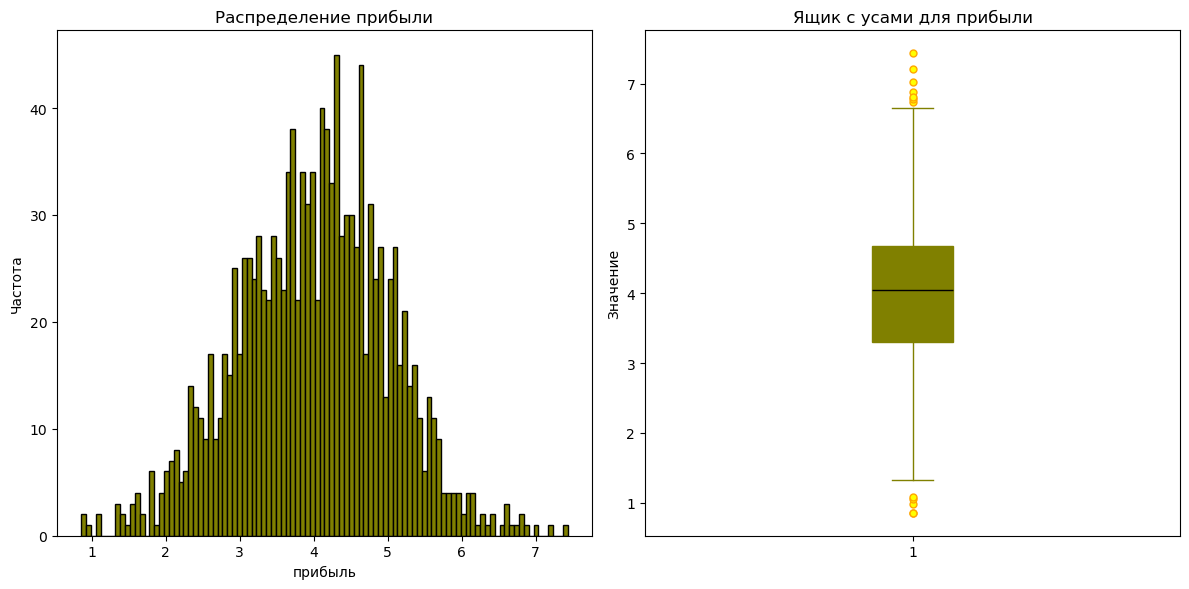

In [61]:
distribution_image(money['прибыль'], col1='прибыли', col2='прибыль', color='olive')

🟠 В других таблицах распределение признаков похоже на нормальное, в частности, это касается выручки и прибыли, в меньшей степени распределение минут похоже на нормальное. В таблице market_money есть выбросы, выручка от одного из клиентов превысила 100 тыс. руб. Также выбросы есть в таблице money. Необходимо это иметь в виду. 

### Распределение категориальных признаков

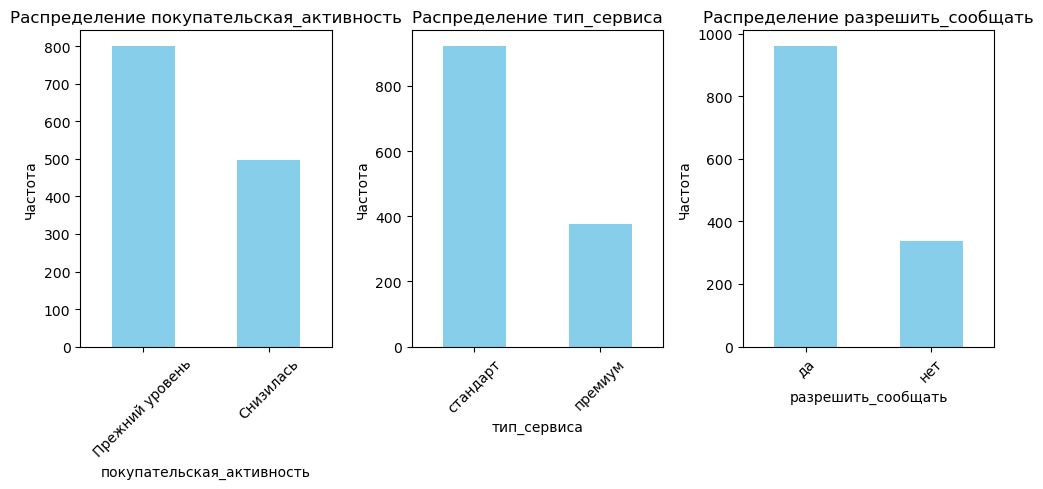

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axes = axes.flatten()

for i, col in enumerate(cat_columns[:3]):
    market[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Распределение {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [65]:
market['покупательская_активность'].value_counts(normalize=True)

покупательская_активность
Прежний уровень   0.62
Снизилась         0.38
Name: proportion, dtype: float64

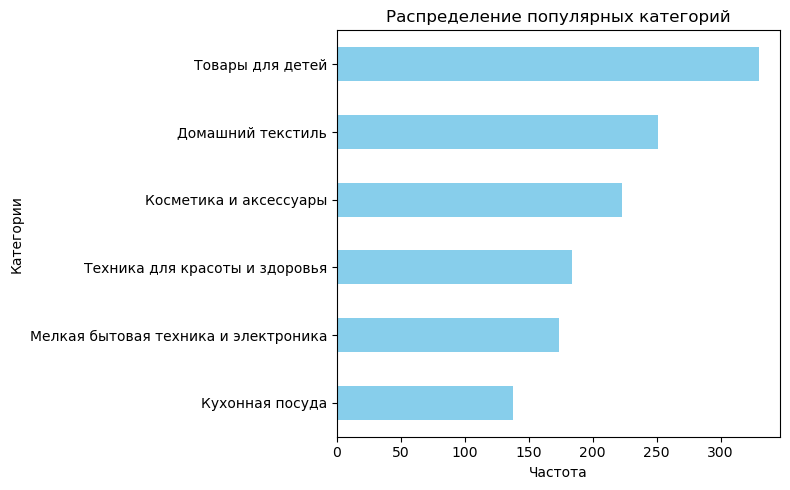

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
sorted_series = market['популярная_категория'].value_counts(ascending=True)
sorted_series.plot(kind='barh', ax=axes, color='skyblue')
axes.set_title('Распределение популярных категорий')
axes.tick_params(axis='y', rotation=0)
axes.set_xlabel('Частота')
axes.set_ylabel('Категории')
plt.tight_layout()
plt.show()

In [67]:
df_plot = market_money.groupby('период')['выручка'].sum().reset_index()
df_plot

,период,выручка
0,предыдущий_месяц,"6,417,996.50"
1,препредыдущий_месяц,"6,272,769.00"
2,текущий_месяц,"6,909,449.10"


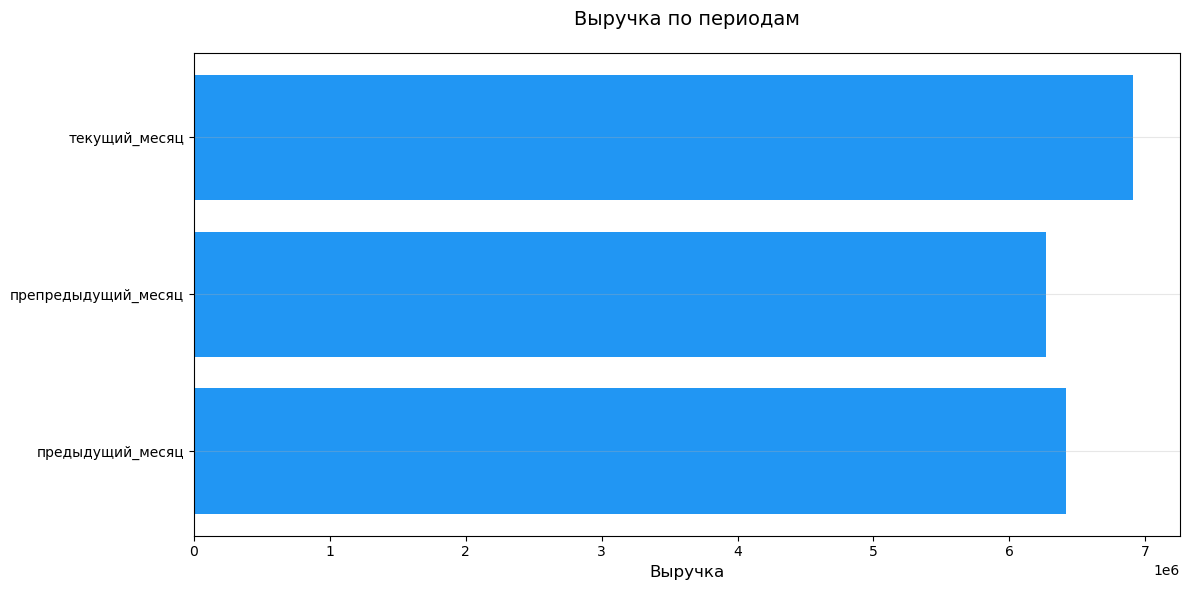

In [68]:
plt.figure(figsize=(12, 6))
plt.barh(df_plot['период'], df_plot['выручка'], color='#2196F3')
plt.title('Выручка по периодам', fontsize=14, pad=20)
plt.xlabel('Выручка', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [69]:
df_plot = market_time.groupby('период')['минут'].sum().reset_index()
df_plot

,период,минут
0,предыдущий_месяц,17508
1,текущий_месяц,17166


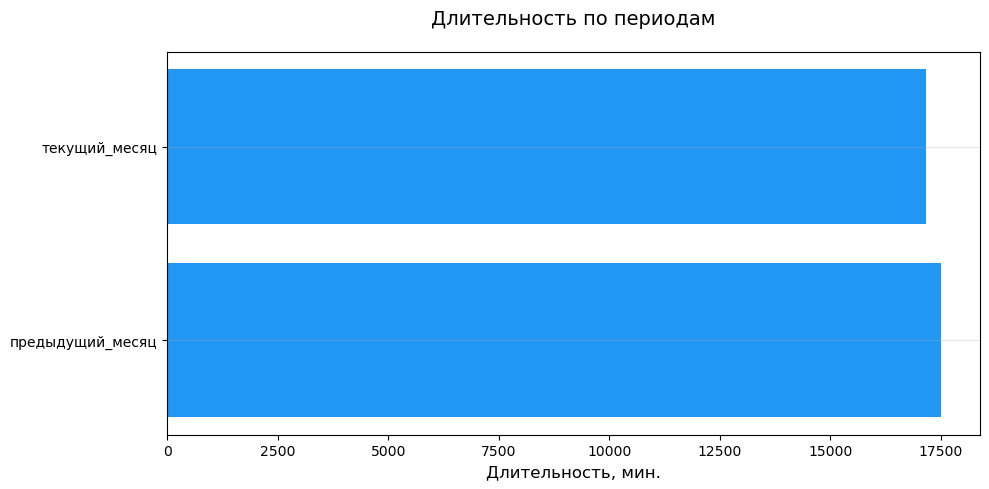

In [70]:
plt.figure(figsize=(10, 5))
plt.barh(df_plot['период'], df_plot['минут'], color='#2196F3')
plt.title('Длительность по периодам', fontsize=14, pad=20)
plt.xlabel('Длительность, мин.', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

🟠 В категориальных признаках в основной таблице market данные распределены неравномерно. Клиентов, у которых активность не снизилась, больше. Преобладают покупатели, которрые не пользуются премиум сервисом. В основном клиенты готовы поллучать рассылки.

Лидирует категория детских товаров, также у клиентов пользуются спросом домашний текстить и косметика и аксессуары.

В других таблицах были рассмотрены распределения численных признаков по временным периодам. В основном данные распределены равномерно.

In [72]:
df = market_money.pivot(index='id', columns='период', values='выручка').reset_index()

In [73]:
df[(df['предыдущий_месяц'] == 0) | (df['препредыдущий_месяц'] == 0) | (df['текущий_месяц'] == 0)]

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,0.00,0.00,"3,293.10"
9,215357,0.00,0.00,"5,986.30"
11,215359,0.00,0.00,"4,735.00"


In [74]:
revenue = market_money[market_money['id'] != 215348]
revenue = revenue[revenue['id'] != 215357]
revenue = revenue[revenue['id'] != 215359]

In [75]:
market_money.shape

(3900, 3)

In [76]:
revenue.shape

(3891, 3)

✅ В таблице market численные признаки в основном распределены не нормально. У нескольких числовых ппризнаков наблюдается малое количество значений, например, маркетинговая активность в текущем месяце имеет всего три значения. Значения категориальных признаков не сбалансированы. В том числе есть дисбаланс в целевом признаке. Покупателей с обычной активностью больше, чем тех, у которых она снизилась.

В даннных по выручке есть выбросы, при этом данные распределены нормально. Выручка по периодам в целом распределена равномерно, в текущем месяце она немного больше. 

В параметре "длительность" нет выбросов. Распределение по минутам тяготеет к нормальному, есть скос справа. Минуты по периодам распределелны равномерно.

В данных по прибыли есть выборсы, распределение похоже на нормальное.

Согласно данным по выручке, в таблицу попали три клиента, у которых в какой-либо из трех месяцев была нулевая выручка. Скорее всего это новые покупатели, у всех троих покупки были только в текущем месяце. Решено удалить этих покупателей из таблицы с выручкой и обратить на это внимание при объединении таблиц.

## Шаг 4. Объединение таблиц

In [79]:
revenue_pivot = revenue.pivot(index='id', columns='период', values='выручка').reset_index()

In [80]:
market_time_pivot = market_time.pivot(index='id', columns='период', values='минут').reset_index()

In [81]:
revenue_pivot.columns = [
    'id', 
    'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц'
]

In [82]:
market_time_pivot.columns = [
    'id',
    'минуты_предыдущий_месяц',
    'минуты_текущий_месяц'
]

In [83]:
data = revenue_pivot.merge(market, on='id', how='left').merge(market_time_pivot, on='id', how='left')

In [84]:
data.tail()

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц
1292,216643,"3,664.00","4,704.00","4,741.70",Прежний уровень,стандарт,да,6.60,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7
1293,216644,"4,729.00","5,299.00","5,353.00",Прежний уровень,стандарт,нет,5.10,4,454,0.21,Домашний текстиль,6,2,3,9,12,11
1294,216645,"5,160.00","5,334.00","5,139.20",Прежний уровень,стандарт,да,4.10,3,586,0.20,Домашний текстиль,3,2,5,7,12,18
1295,216646,"4,923.00","4,725.00","5,224.60",Прежний уровень,стандарт,да,6.30,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7
1296,216647,"4,720.00","5,183.00","4,448.30",Прежний уровень,премиум,да,4.00,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,15,10


In [85]:
print(revenue.shape) #размер без новых покупателей, это узкая таблица категории не разнесены по отдельным столбцам.
#После разнесения по новым столбцам добавит три новых признака.
print(market.shape) #начальный размер основной таблицы (вместе с 3 "ненужными" клиентами), 
#то есть в итоговой таблице должно быть 1300 - 3 = 1297
print(market_time.shape)#узкая таблица, включает "ненужных" клиентов, добавит два столбца в итоговую
print(data.shape)# итоговая таблица с необходимым кол-ом строк 1297, и корректным числом признаков –
# 13 + 3 + 2 = 18

(3891, 3)
(1300, 13)
(2600, 3)
(1297, 18)


✅ Перед объединением таблиц необходимо было создать отдельный столбец для каждого периода с выручкой и минутами, проведенными на сайте. Кроме того надо было изменить названия столбцов в преобразованных таблицах, чтобы они не перепутались при объединении. Для объединения был выбран метод merge(), чтобы объединить по столбцу 'id'. На первое место была поставлена таблица с прибылью, где уже были удалены покупатели, которые не подходят для исследования, и использован параметр left, чтобы в объединенной таблице были только те id, которые были в таблице с выручкой без "лишних" покупателей. Объединение прошло нормально.

## Шаг 5. Корреляционный анализ

In [88]:
df_without_id = data.drop(columns=['id'])
interval_cols = [
        'выручка_предыдущий_месяц',
        'выручка_препредыдущий_месяц',
        'выручка_текущий_месяц',
        'маркет_актив_6_мес', 
        'длительность',
        'акционные_покупки'
]
phik_overview = phik_matrix(df_without_id, interval_cols=interval_cols)

In [89]:
print(len(data['акционные_покупки'].value_counts()))
print(len(data['маркет_актив_6_мес'].value_counts()))
print(len(data['выручка_предыдущий_месяц'].value_counts()))
print(len(data['длительность'].value_counts()))

41
41
1121
657


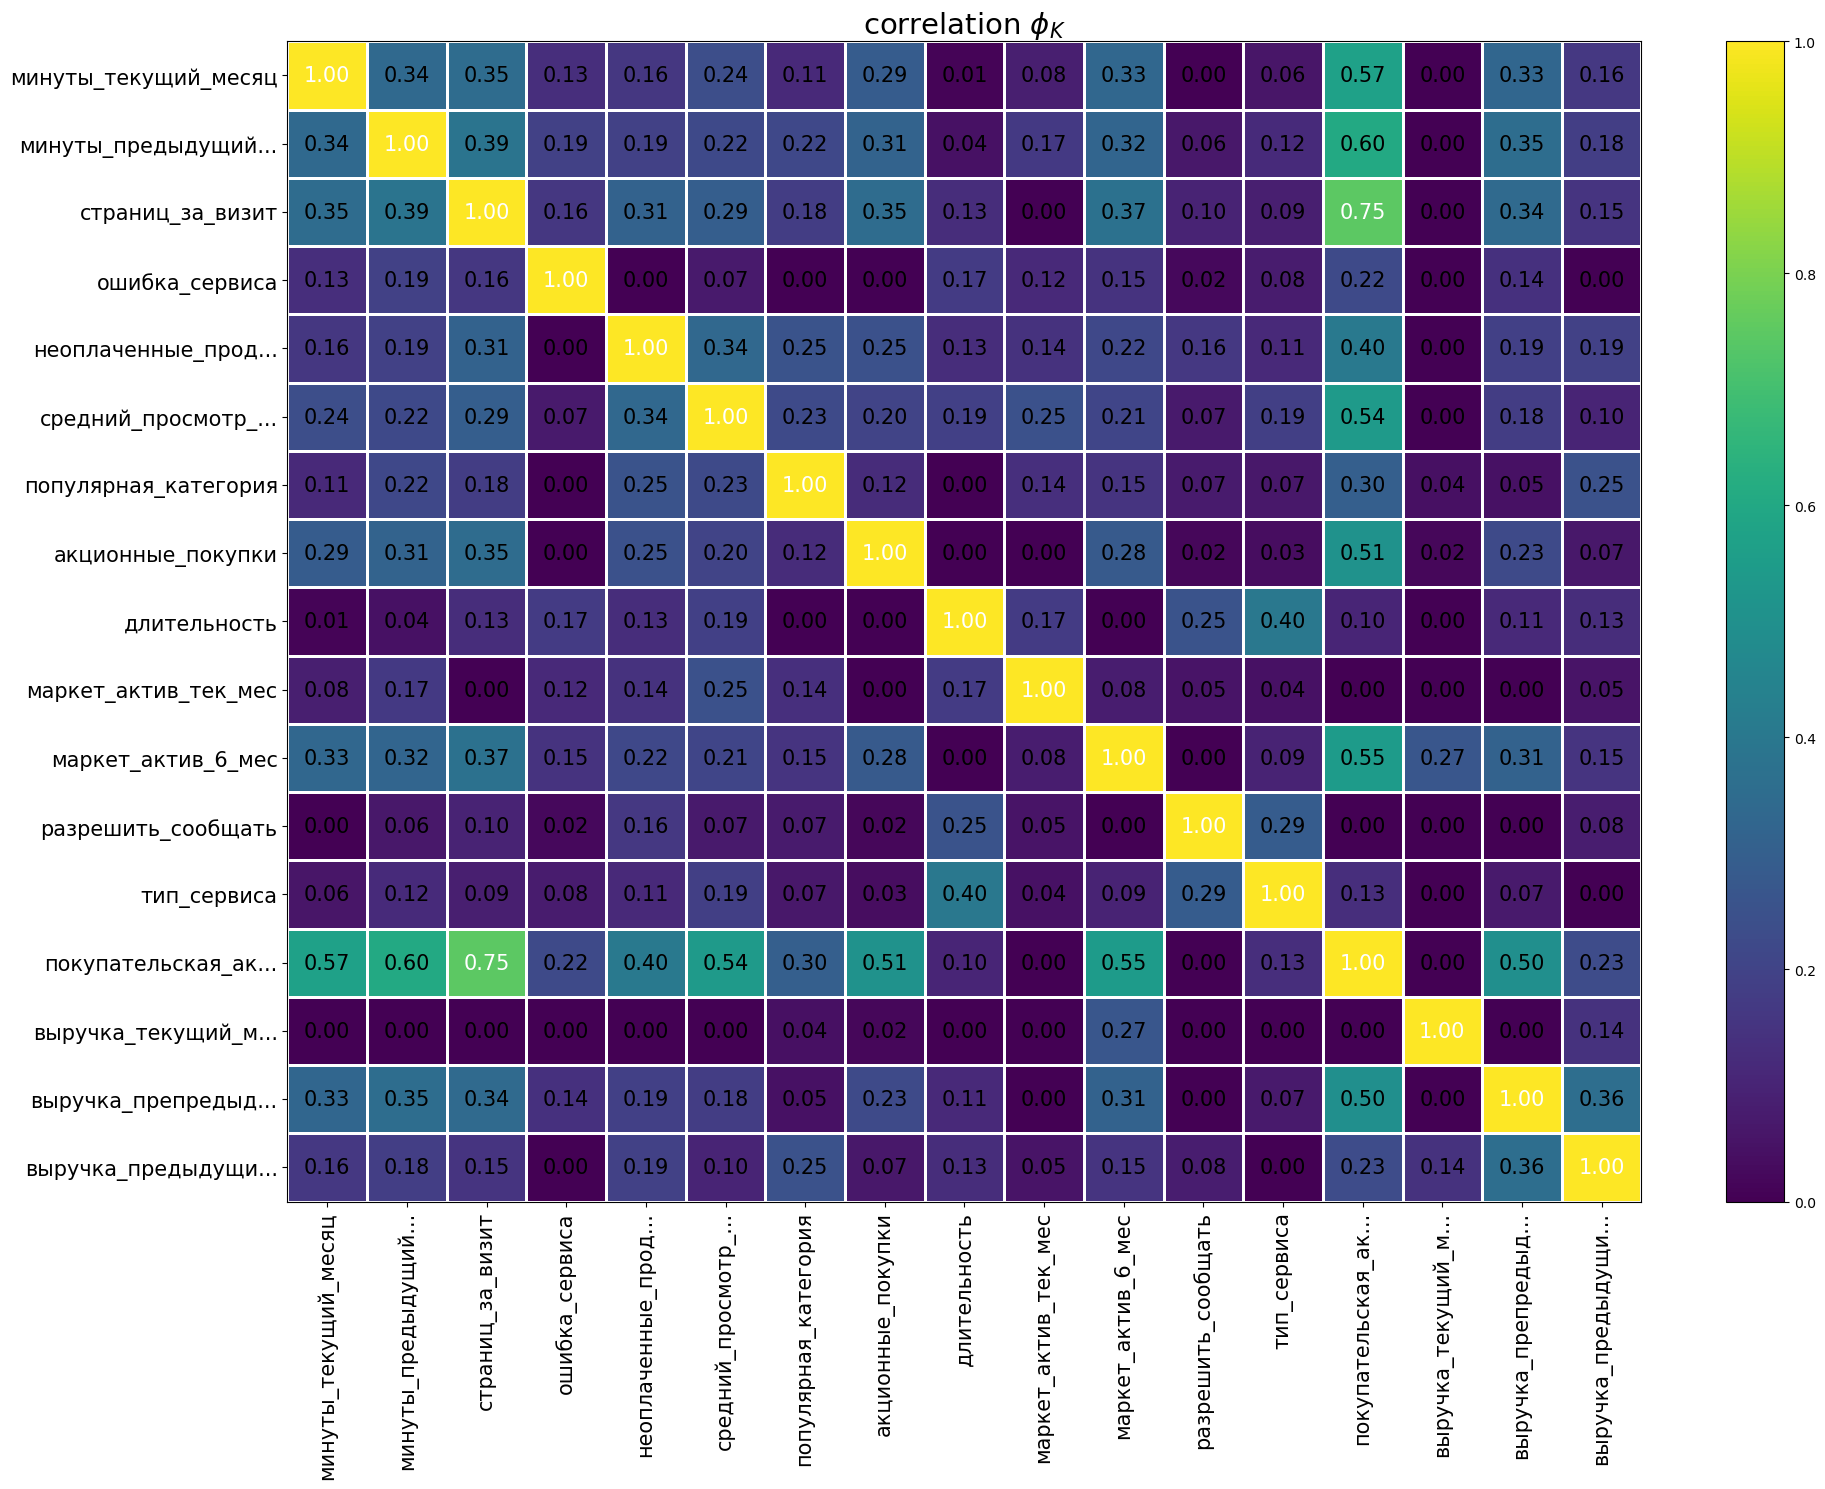

In [90]:

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='viridis',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

✅ Так как в основном количественные признаки имеют ненормальное распределение, длля исследования корреляции используем корреляцию Phik. С помощью матрицы корреляции можно заметить, что мультиколлиниарности между признаками нет. Однако вызывает вопрос взаимосвязь целевого признака покупательской активности и количество просмотренных страниц за визит. Логично, что чем больше этот показатель, тем больше активность. Но это средний показатель за предыдущие месяцы, он заранее известен, поэтому здесь не должно произойти утечки целевого признака.

## Шаг 6. Использование пайплайнов

In [93]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors")

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['покупательская_активность','id'], axis=1),
    data['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['покупательская_активность'])

In [95]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test) 

num_columns = X_train.select_dtypes(include='number').columns.tolist()
ord_columns = ['тип_сервиса']
ohe_columns = ['разрешить_сообщать', 'популярная_категория']

ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(
                categories= [
                    
                    ['стандарт', 'премиум']],

                handle_unknown='use_encoded_value', unknown_value=np.nan 
            )
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['rbf','sigmoid', 'linear', 'poly'],
        'models__C': [0.1, 1, 10], 
        'models__gamma': [0.1, 1, 'scale', 'auto'],
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1500, tol=1e-4)],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear'],
        'models__C': range(1, 5),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

print('Лучшая модель и ее параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                 

In [96]:
model_pipeline = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('classifier', DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1
    ))
])


model_pipeline.fit(X_train, y_train)


y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)



print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.8646153846153846
F1: 0.8765957446808511


In [97]:
model_pipeline = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('classifier', SVC(probability=True, random_state=RANDOM_STATE)
    )
])


model_pipeline.fit(X_train, y_train)


y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)



print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.9076923076923077
F1: 0.8765957446808511


In [98]:
data['покупательская_активность'].value_counts(normalize=True)

покупательская_активность
Прежний уровень   0.62
Снизилась         0.38
Name: proportion, dtype: float64

✅ Для моделирования решено выбрать f1_score, так как есть умеренный дисбаланс классов (примерно 2 к 1), так как аccuracy не замечает проблемы модели из-за дисбаланса классов. F1-мера снижается, когда модель из-за дисбаланса плохо предсказывает минорный класс, поэтому нужно смотреть именно на нее. Дисбаланс учтен также при делении данных на тренировочную и тестовую выборки. Кроме того для моделей, где есть взвешивание классов – SVC, LogisticRegression, DecisionTreeClassifier – для подбора гиперпараметров добавлен class_weight. Так как у некоторых моделей было много гиперпараметров для подбора GridSearchCV не использовался. Несмотря на небольшой объем данных, он медленно работал. Была попытка использовать OptunaSearchCV, возникли некоторые технические сложности, в итоге получила лучшую модель такую же как и при RandomizedSearchCV – SVC.

>Лучшие параметры: {'models__kernel': 'rbf', 'models__C': 1.6939944162092635, 'models__gamma': 0.1, 'models__class_weight': None} F1 на тренировке: 0.8444559110193787 F1 на тесте: 0.858

Однако у выбранной RandomizedSearchCV модели метрика на тесте лучше – 0.876 у рандомного против 0.858 у байесовского, поэтому дальше решено было работать с RandomizedSearchCV. 

Итоговая модель - метод опорных векторов с ядром rbf (стоит по умолчанию) и следующими гиперпаратметрами:

>SVC(C=0.1, class_weight='balanced', gamma='auto', probability=True, random_state=42

## Шаг 7. Анализ важности признаков

    Так как библиотека SHAP не стабильно работает с SVC, для выполнения задания решено было взять вторую по эффективности модель.

In [102]:
results = pd.DataFrame(randomized_search.cv_results_)

sorted_results = results.sort_values(by='mean_test_score', ascending=False)


second_best_params = sorted_results.iloc[1]['params']
second_best_score = sorted_results.iloc[1]['mean_test_score']

print("Вторая лучшая модель:")
print(f"Параметры: {second_best_params}")
print(f"F1-score: {second_best_score:.3f}")

Вторая лучшая модель:
Параметры: {'preprocessor__num': StandardScaler(), 'models__kernel': 'linear', 'models__gamma': 0.1, 'models__class_weight': None, 'models__C': 10, 'models': SVC(probability=True, random_state=42)}
F1-score: 0.806


    Это тоже SVC, но с линейным ядром. С ним SHAP работает лучше, поэтому берем эту модель.

In [104]:
#Извлекаем подготовленные данные из пайплана.
data_preprocessor.fit(X_train)
ohe = data_preprocessor.named_transformers_['ohe'].named_steps['ohe']
ord_ = data_preprocessor.named_transformers_['ord'].named_steps['ord']
ord_feature_names = ord_.get_feature_names_out(input_features=ord_columns)
ohe_feature_names = ohe.get_feature_names_out(input_features=ohe_columns)
all_feature_names = list(ohe_feature_names) + list(ord_feature_names) + list(num_columns)
X_trans = data_preprocessor.transform(X_train)
X_trans_df = pd.DataFrame(X_trans, columns=all_feature_names)

In [105]:
#Отдельно для визуализации SHAP прописываем нужную модель.
model = SVC(
        kernel='linear',
        C=0.1, 
        class_weight='balanced', 
        gamma='auto', 
        probability=True, 
        random_state=42)
model.fit(X_trans, y_train)

explainer = shap.Explainer(model, X_trans_df)
shap_values = explainer(X_trans_df)

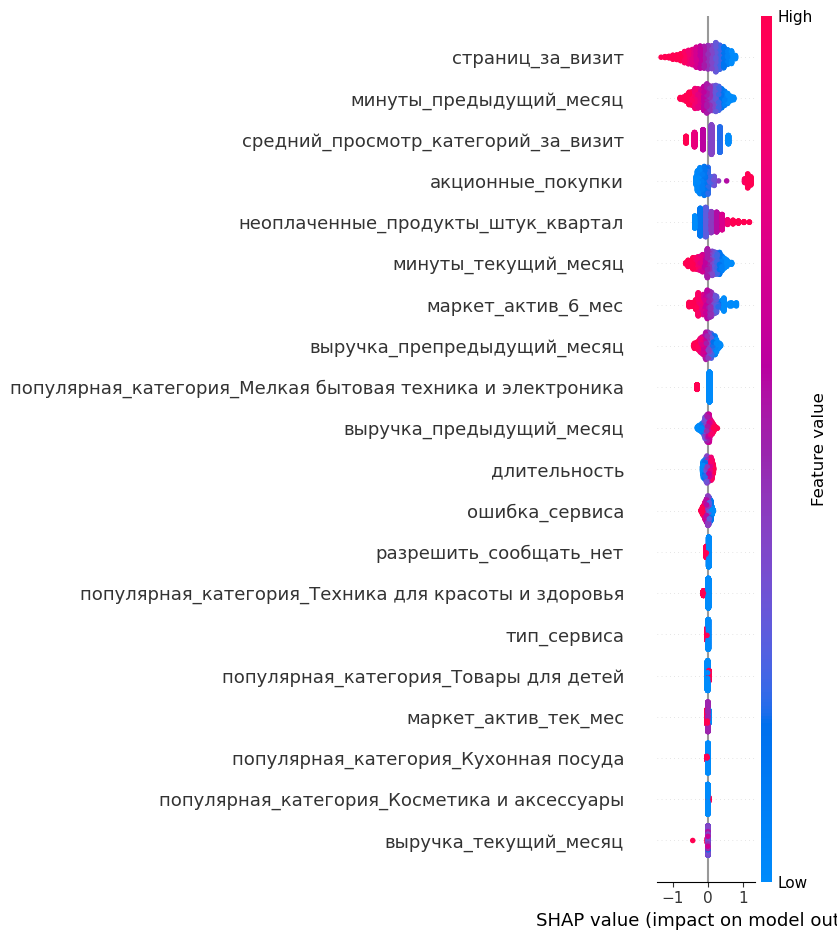

In [106]:
shap.summary_plot(shap_values.values, features=X_trans_df, feature_names=shap_values.feature_names)

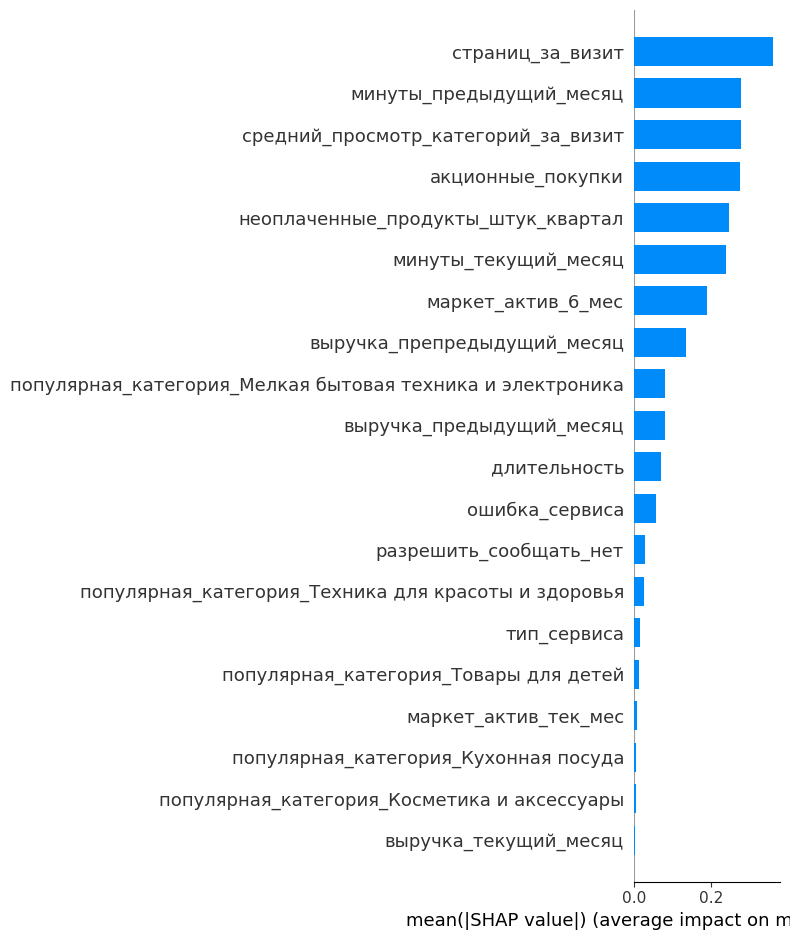

In [107]:
shap.summary_plot(shap_values.values, 
                  features=X_trans_df, 
                  feature_names=all_feature_names, 
                  plot_type='bar')

🟠 Диаграммы получились немного вытянутыми, так как анализировались 20 признаков. Анализ SHAP показал,что наибольший вклад в прогноз модели внесли количество просмотренных страниц за визит, минуты, проведенные на сайте в предыдущий месяц, средний просмотр категорий за визит, количество акционных покупок. Выбор модели укладывается в рамки здравого смысла. Например, на shap.summary_plot видно, что при высоком значении просмотренных страниц за визит модель относит объект к классу 0 ("прежняя активность"). Действительно, если человек просматривает много страниц, значит, он заинтересован в поиске какого-либо товара.

Интересно, что в число довольно влиятельных признаков попала маркетинговая активность за последние шесть месяцев. А вот маркетинговая активность текущего месяца роли не сыграла. Стоит изучить этот вопрос подробнее.

Также, кажется, не важно какую категорию предпочитает покупатель, его покупательская активность от этого зависит не очень сильно.

    Модель показала, что в первую очередь она ориентировалась на количество просмостров страниц, количество проведенных минут на сайте и др. Сравним некоторые из этих признаков с разными категориями покупателей.

In [110]:
norm = data[data['покупательская_активность'] == 'Прежний уровень']
drop = data[data['покупательская_активность'] == 'Снизилась']

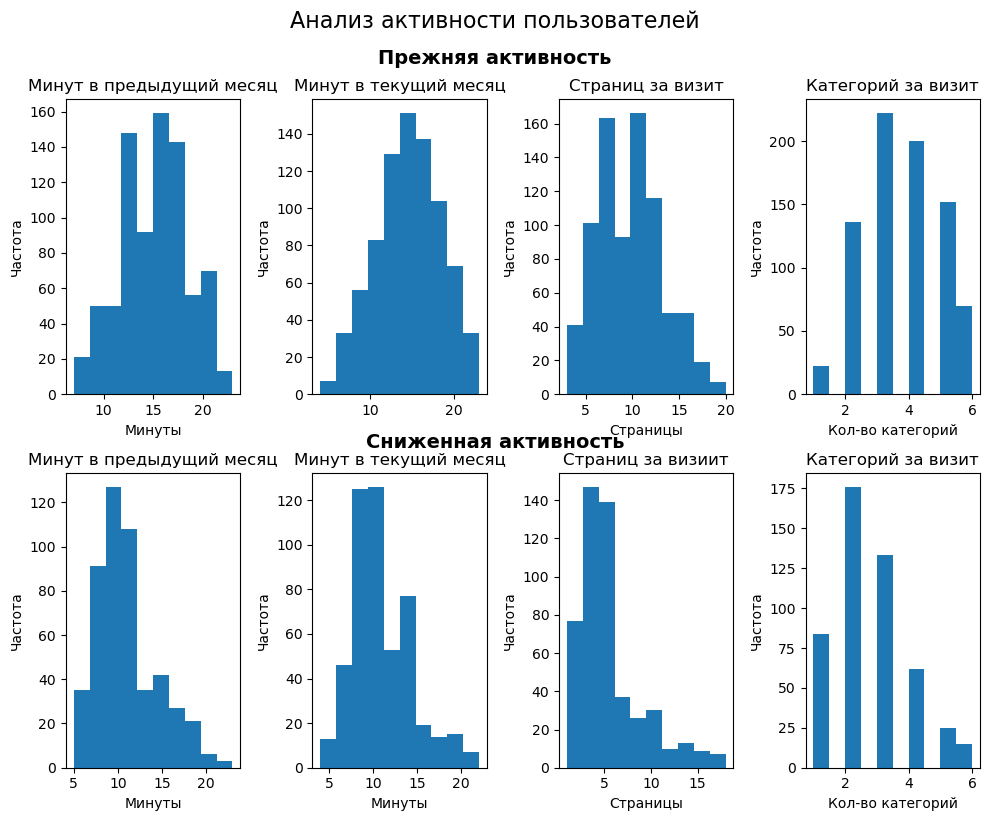

In [111]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 8))


axes[0, 0].hist(norm['минуты_предыдущий_месяц'])
axes[0, 0].set_title('Минут в предыдущий месяц')
axes[0, 0].set_xlabel('Минуты')
axes[0, 0].set_ylabel('Частота')

axes[0, 1].hist(norm['минуты_текущий_месяц'])
axes[0, 1].set_title('Минут в текущий месяц')
axes[0, 1].set_ylabel('Частота')


axes[0, 2].hist(norm['страниц_за_визит'])
axes[0, 2].set_title('Страниц за визит')
axes[0, 2].set_xlabel('Страницы')
axes[0, 2].set_ylabel('Частота')

axes[0, 3].hist(norm['средний_просмотр_категорий_за_визит'])
axes[0, 3].set_title('Категорий за визит')
axes[0, 3].set_xlabel('Кол-во категорий')
axes[0, 3].set_ylabel('Частота')

fig.text(0.5, 0.96, 'Прежняя активность', 
         ha='center', va='center', fontsize=14, fontweight='bold')


axes[1, 0].hist(drop['минуты_предыдущий_месяц'])
axes[1, 0].set_title('Минут в предыдущий месяц')
axes[1, 0].set_xlabel('Минуты')
axes[1, 0].set_ylabel('Частота')

axes[1, 1].hist(drop['минуты_текущий_месяц'])
axes[1, 1].set_title('Минут в текущий месяц')
axes[1, 1].set_xlabel('Минуты')
axes[1, 1].set_ylabel('Частота')

axes[1, 2].hist(drop['страниц_за_визит'])
axes[1, 2].set_title('Страниц за визиит')
axes[1, 2].set_xlabel('Страницы')
axes[1, 2].set_ylabel('Частота')

axes[1, 3].hist(drop['средний_просмотр_категорий_за_визит'])
axes[1, 3].set_title('Категорий за визит')
axes[1, 3].set_xlabel('Кол-во категорий')
axes[1, 3].set_ylabel('Частота')

fig.text(0.5, 0.48, 'Сниженная активность', 
         ha='center', va='center', fontsize=14, fontweight='bold')

fig.suptitle('Анализ активности пользователей', fontsize=16, y=1.02)


plt.tight_layout()
plt.show()

🟠  Вполне логично, что при снижении активности, снижается время, проведенное на сайте, количество просмотренных страниц и категорий.

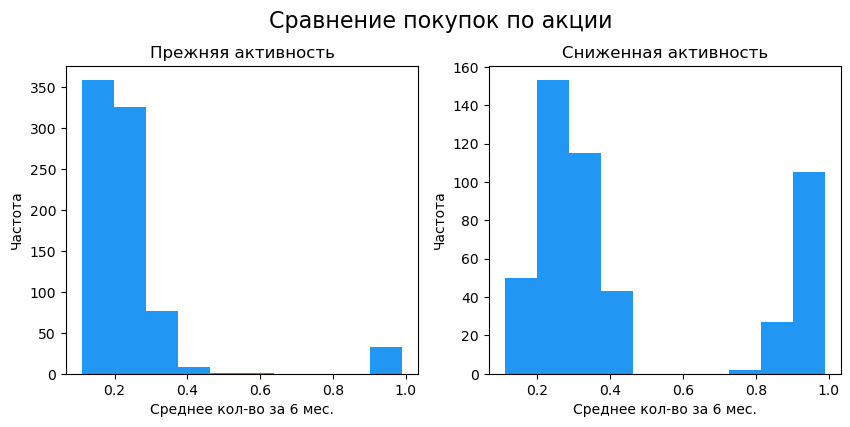

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


axes[0].hist(norm['акционные_покупки'], color='#2196F3')
axes[0].set_title('Прежняя активность')
axes[0].set_xlabel('Среднее кол-во за 6 мес.')
axes[0].set_ylabel('Частота')

axes[1].hist(drop['акционные_покупки'], color='#2196F3')
axes[1].set_title('Cниженная активность')
axes[1].set_xlabel('Среднее кол-во за 6 мес.')
axes[1].set_ylabel('Частота')

fig.suptitle('Сравнение покупок по акции', fontsize=16, y=1.02);

🟠 Покупатели со сниженной активностью чаще предпочитают акционные продукты, что тоже вполне объяснимо.

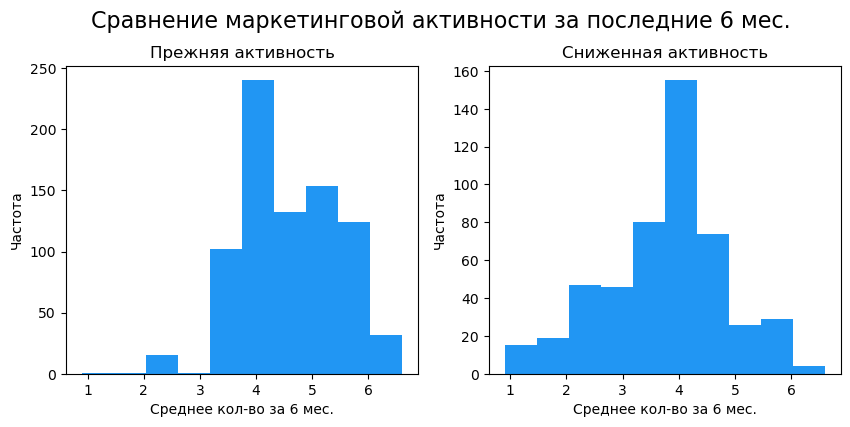

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


axes[0].hist(norm['маркет_актив_6_мес'], color='#2196F3')
axes[0].set_title('Прежняя активность')
axes[0].set_xlabel('Среднее кол-во за 6 мес.')
axes[0].set_ylabel('Частота')

axes[1].hist(drop['маркет_актив_6_мес'], color='#2196F3')
axes[1].set_title('Cниженная активность')
axes[1].set_xlabel('Среднее кол-во за 6 мес.')
axes[1].set_ylabel('Частота')

fig.suptitle('Сравнение маркетинговой активности за последние 6 мес.', fontsize=16, y=1.02);

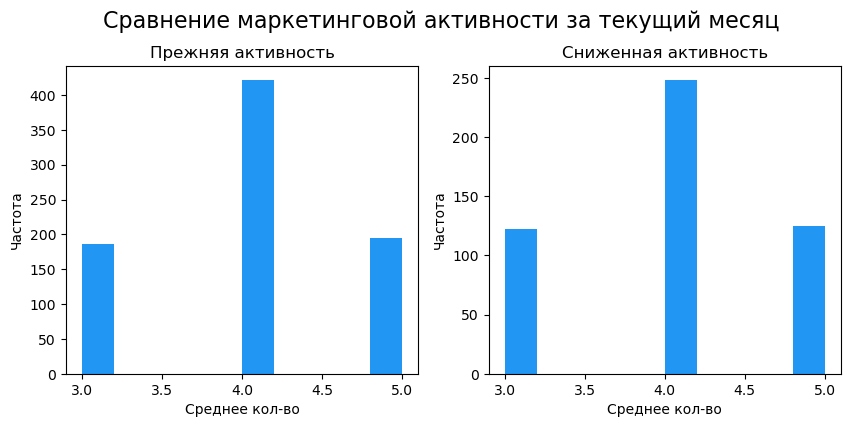

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


axes[0].hist(norm['маркет_актив_тек_мес'], color='#2196F3')
axes[0].set_title('Прежняя активность')
axes[0].set_xlabel('Среднее кол-во')
axes[0].set_ylabel('Частота')

axes[1].hist(drop['маркет_актив_тек_мес'], color='#2196F3')
axes[1].set_title('Cниженная активность')
axes[1].set_xlabel('Среднее кол-во')
axes[1].set_ylabel('Частота')

fig.suptitle('Сравнение маркетинговой активности за текущий месяц', fontsize=16, y=1.02);

🟠 Кажется теперь понятно, в чем дело. В последние шесть месяцев для покупателей с обычной активностью было больше маркетинговых мероприятий. На диаграмме распределения видно, что большинство объектов расположены справа от значения 4, а в последний месяц маркетинговая активность была для всех одинаковой. Стоит проанализировать маркетинговые мероприятия внимательней.

In [118]:
norm_profit = norm.merge(money, on='id', how='left')
drop_profit = drop.merge(money, on='id', how='left')

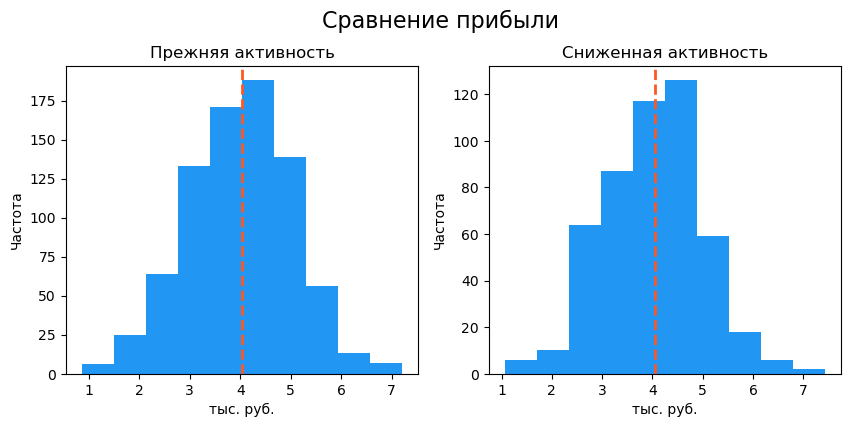

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


axes[0].hist(norm_profit['прибыль'], color='#2196F3')
median_norm = np.median(norm_profit['прибыль'])
axes[0].axvline(median_norm, color='#FF5722', linestyle='--', linewidth=2, 
                label=f'Медиана: {median_norm:.1f} тыс. руб.')
axes[0].set_title('Прежняя активность')
axes[0].set_xlabel('тыс. руб.')
axes[0].set_ylabel('Частота')

axes[1].hist(drop_profit['прибыль'], color='#2196F3')
median_drop = np.median(drop_profit['прибыль'])
axes[1].axvline(median_drop, color='#FF5722', linestyle='--', linewidth=2, 
                label=f'Медиана: {median_drop:.1f} тыс. руб.')
axes[1].set_title('Сниженная активность')
axes[1].set_xlabel('тыс. руб.')
axes[1].set_ylabel('Частота')

fig.suptitle('Сравнение прибыли', fontsize=16, y=1.02);

🟠 Прибыль от обеих категорий покупателей сопоставима, но у покупателей со сниженной активность есть небольшой скос справа, объектов с прибылью меньше 4 больше. 

✅ Анализ с помощью библиотеки SHSAP показал, что модель выбрала вполне очевидные признаки для предсказания активности покупателей, ориентируясь, сколько покупатель проводит времени на сайте, количество страниц и категорий.

Вполне предсказуемо, если клиент покупает в основном товары по акции, то может быть это пока не постоянный покупатель, он пришел недавно, его заинтересовали акционные товары, но дальше этого пока не пошло, либо это просто такой тип покупателей. В таком случае, если нет акций, то снижается и активность. 

Для покупателей, у которых осталась прежняя активность, возможно, было чуть больше маркетинговых мероприятий. В последний месяц количество маркетинговых мероприятий распределено равномерно. Может быть, за последние шесть месяцев были какие-то специальные акции для определенных категорий покупателей, благодаря этому покупательская активность была сохранена. Наверное, это важная информация для маркетинговой отдела.

Также стоит отметить, что возможно необходимо было бы избавиться от некоторого количества признаков, так как некоторые из них внесли небольшой вклад в способность модели сделать прогноз. Однако для этого задания было важно понять, какие признаки влияют, а какие не влияют на покутельскую активность. 

## Шаг 8. Сегментация покупателей

    Для начала создадим таблицу с предсказанными вероятностями для тестовой выборки. По этой выборке будем сегментировать покупателей, чтобы подготовить рекомендации для них.

In [124]:
best_model = randomized_search.best_estimator_
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

In [125]:
#Добавляем столбцы с вероятностями, предсказанными классами в тестовую выборку
result = X_test.copy()
result['вероятность_снижения'] = y_test_proba
result['истинное_значение'] = label_encoder.inverse_transform(y_test)
result['предсказанный класс'] = y_test_pred

In [126]:
#Теперь выбираем таргетную группы клиентов, добавляем прибыль
target_group = result[result['предсказанный класс'] == 1]
target_group_merged = pd.merge(target_group, money, left_index=True, right_index=True, how='inner')
target_group_merged = target_group_merged.drop(['id'], axis=1)

In [127]:
target_group_merged.head()

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,вероятность_снижения,истинное_значение,предсказанный класс,прибыль
118,"5,403.50","4,889.00","5,228.00",премиум,да,4.10,3,813,0.22,Домашний текстиль,3,3,4,5,12,8,0.81,Снизилась,1,2.99
362,"4,821.00","4,872.00","5,221.40",стандарт,да,4.60,5,293,0.24,Товары для детей,1,3,3,3,12,14,0.75,Снизилась,1,3.59
149,"4,137.00","4,278.00","3,808.10",стандарт,да,3.50,4,573,0.40,Косметика и аксессуары,2,4,1,4,11,12,0.97,Снизилась,1,4.17
1005,"5,542.50","5,082.00","6,071.60",стандарт,да,5.50,4,1022,0.91,Мелкая бытовая техника и электроника,3,0,3,11,13,6,0.64,Прежний уровень,1,3.35
7,"4,146.50","4,433.00","4,566.40",стандарт,да,4.20,4,192,0.14,Косметика и аксессуары,2,2,1,3,6,7,0.94,Снизилась,1,5.26


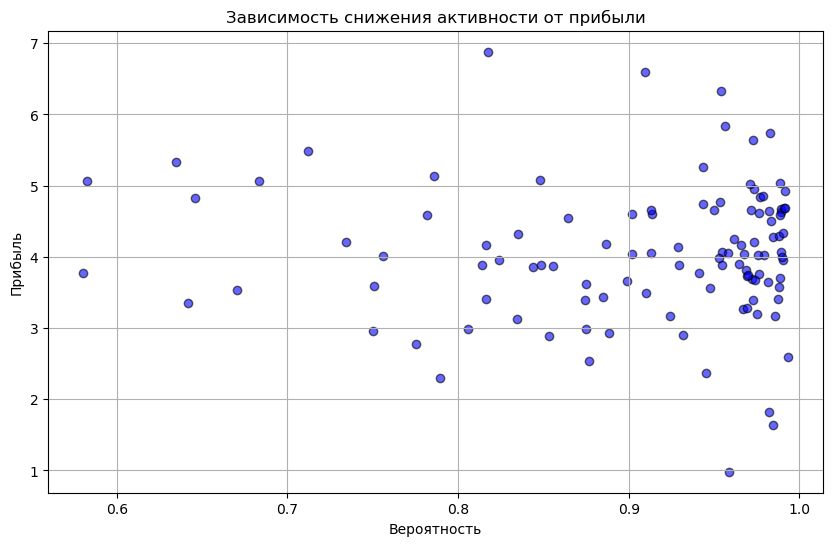

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(
    data=target_group_merged, 
    x='вероятность_снижения', 
    y='прибыль', 
    alpha=0.6, 
    color='blue', 
    edgecolors='black')
plt.title('Зависимость снижения активности от прибыли')
plt.xlabel('Вероятность')
plt.ylabel('Прибыль')
plt.grid(True)
plt.show()

🟠 Распределение прибыли близко к нормальному, поэтому большинство покупателей со сниженной активностью принесли компании прибыль в дапазоне 3-5 тыс. руб. В категорию с высокой вероятностью снижения – от 90% – и большой прибылью – больше 5 тыс. руб., попадает небольшое количество покупателей. Однако это интересная с точки зрения потенциала группа. Попробуем сформировать рекомендации для этой категории.

In [130]:
profitable_clients = target_group_merged[
    (target_group_merged['вероятность_снижения'] > 0.7)
    &
    (target_group_merged['прибыль'] > 5)
]

In [131]:
profitable_clients.shape

(12, 20)

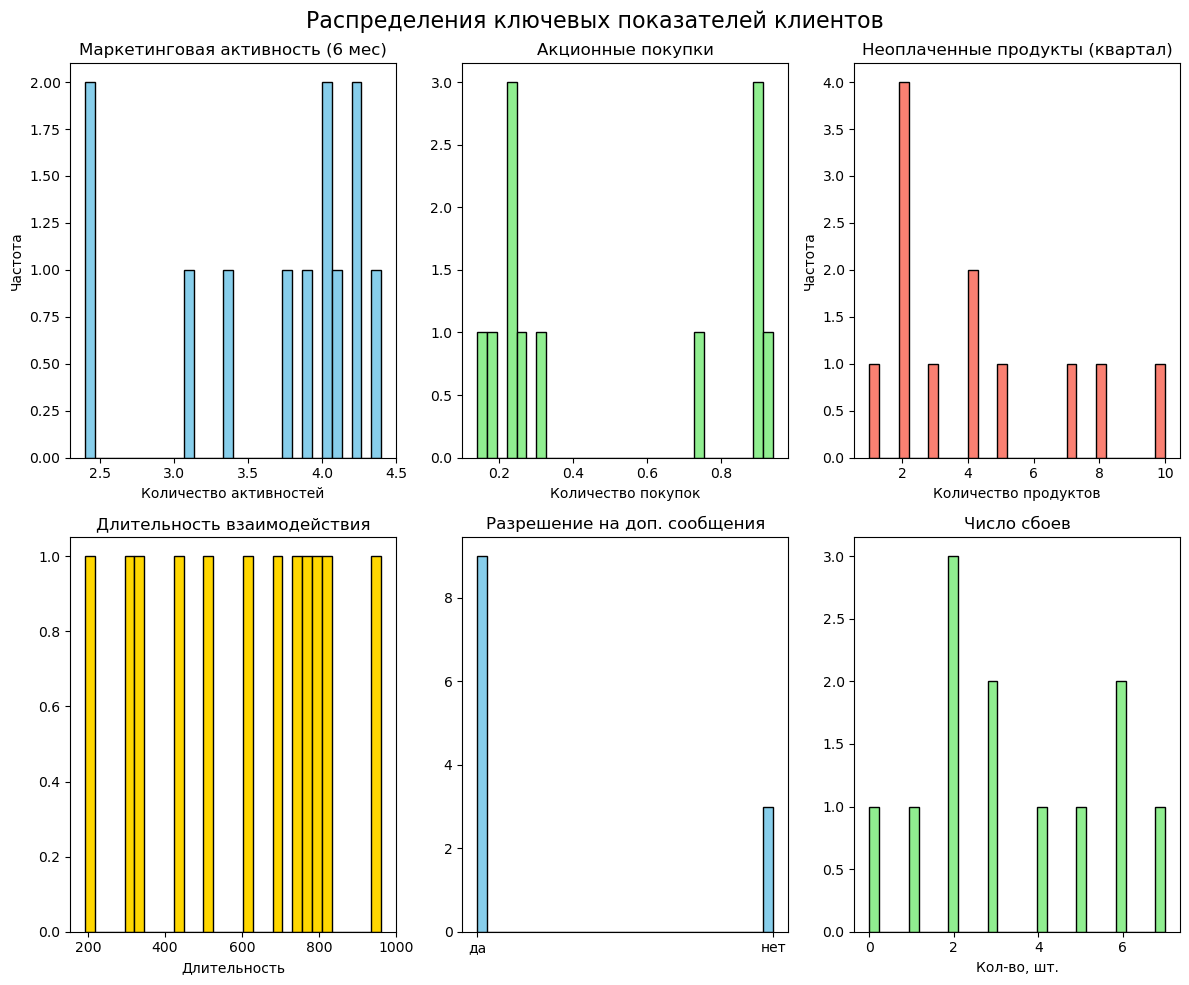

In [132]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
fig.suptitle('Распределения ключевых показателей клиентов', fontsize=16)


axes[0, 0].hist(profitable_clients['маркет_актив_6_мес'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Маркетинговая активность (6 мес)')
axes[0, 0].set_xlabel('Количество активностей')
axes[0, 0].set_ylabel('Частота')


axes[0, 1].hist(profitable_clients['акционные_покупки'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Акционные покупки')
axes[0, 1].set_xlabel('Количество покупок')


axes[0, 2].hist(profitable_clients['неоплаченные_продукты_штук_квартал'], bins=30, color='salmon', edgecolor='black')
axes[0, 2].set_title('Неоплаченные продукты (квартал)')
axes[0, 2].set_xlabel('Количество продуктов')
axes[0, 2].set_ylabel('Частота')


axes[1, 0].hist(profitable_clients['длительность'], bins=30, color='gold', edgecolor='black')
axes[1, 0].set_title('Длительность взаимодействия')
axes[1, 0].set_xlabel('Длительность')

axes[1, 1].hist(profitable_clients['разрешить_сообщать'], bins=30, color='skyblue', edgecolor='black')
axes[1, 1].set_title('Разрешение на доп. сообщения')
axes[1, 1].set_xlabel('')

axes[1, 2].hist(profitable_clients['ошибка_сервиса'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 2].set_title('Число сбоев')
axes[1, 2].set_xlabel('Кол-во, шт.')

plt.tight_layout()
plt.show()

In [133]:
profitable_clients['популярная_категория'].value_counts(normalize=True)

популярная_категория
Косметика и аксессуары                 0.25
Домашний текстиль                      0.25
Техника для красоты и здоровья         0.17
Товары для детей                       0.17
Кухонная посуда                        0.08
Мелкая бытовая техника и электроника   0.08
Name: proportion, dtype: float64

🟠 Проанализируем выбранную категорию по нескольким признакам. Количество маркетинговых мероприятий в основном составило 3-4,5 мероприятия, что меньше чем у киентов с прежней покупательской активностью (3,5-6). 

Доля акционных чуть больше чем у половины (58%) клиентов в категории меньше 40%, у 42% - она выше 70%. Значит, этой группе можно предложить некоторые товары по акции.

У 75% клиентов категории количество неоплаченных покупок не первышает 6.

Все клиенты зарегистрированы на сайте не меньше чем 200 дней, но не больше чем 1000 дней. В основном клиенты сталкивались с небольшим количеством сбоев до 4 штук.

Половина клиентов в категории предпочитают покупать на сайте либо домашний текстиль, либо косметику и аксесуары, по 17% у категорий техника для здоровья и красоты и товары для детей.

✅  Для этой категории покупателей можно предложить следующее:

* Для повышения покупательской активности можно вместе с товарами из популярной категории предлагать продукты из смежной. Например, если у покупателя популярная категория косметика и акссесуары, то с помощью маркетинговых мероприятий (рассылка, рекомендации на сайте) предложить покупателю технику для красоты и здоровья, тем, кто предпочитает покупать домашний текстиль, предложить кухонную посуду или мелкую бытовую технику. 

* Чтобы стимулировать клиента покупать продукты не только по акции, можно составить список интересных новинок, как из популярной категории, так и из смежной. Например, косметика с новым эффектов, оттенком, техника с новыми функциями.

* Для этой группы покупателей заметна немного сниженная маркетинговая активность, поэтому следует ее повысить. В основном покупатели согласны на дополнительные сообщения, значит надо этим пользоваться. 

* Скорее всего не стоит предлагать этой категории покупателей новый бренды в популярной категории товаров в качестве альтернативы покупкам по акции. Скорее всего эти клиенты привержены брендам, в большей степенив новых продуктак их заинтересует функционал, а не цена.

    Можно проанализировать еще одну категорию – покупатели, которые в основном покупают товары по акции.

In [136]:
save = target_group_merged[(target_group_merged['акционные_покупки'] > 0.8)]
save.shape

(38, 20)

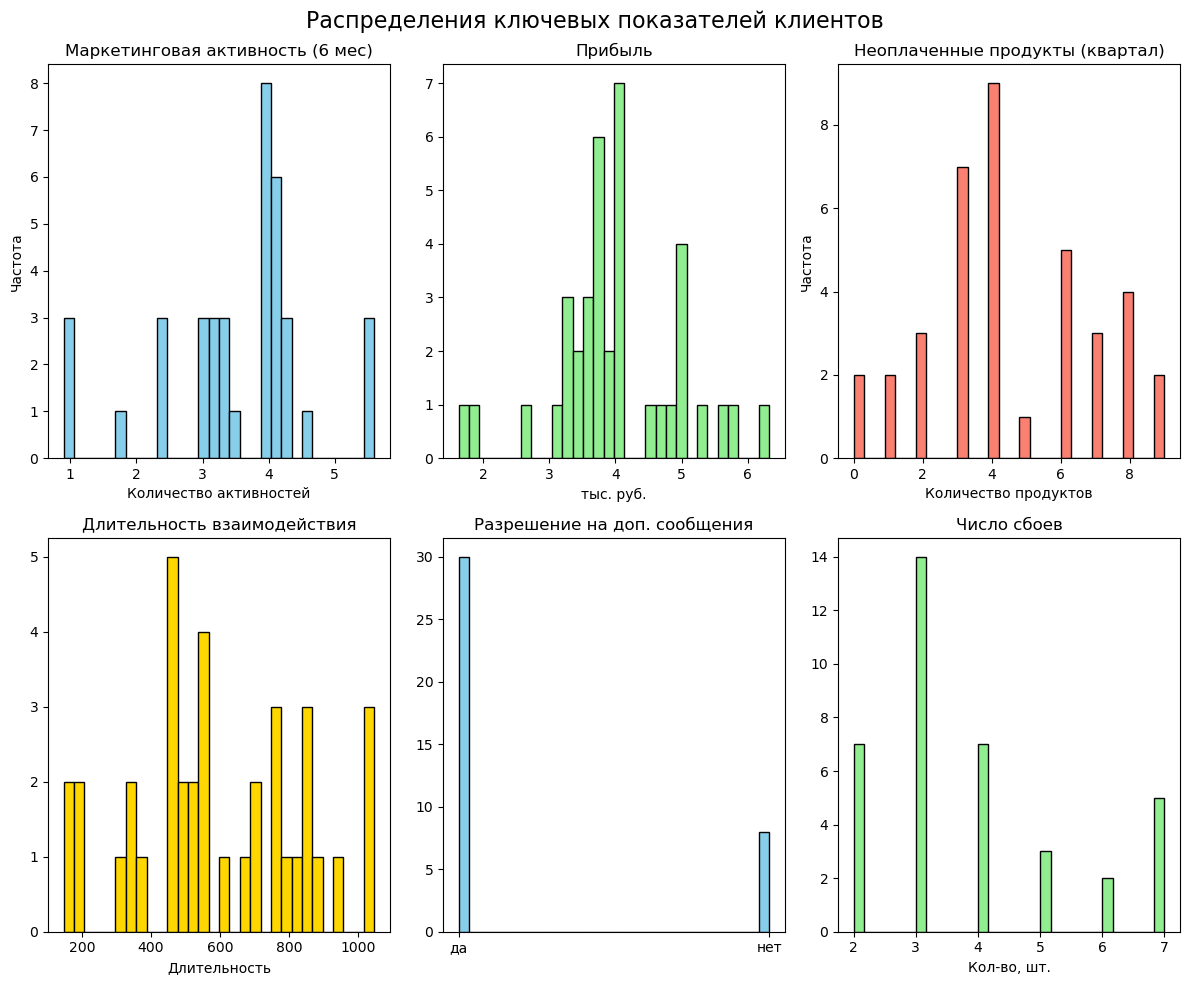

In [137]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
fig.suptitle('Распределения ключевых показателей клиентов', fontsize=16)


axes[0, 0].hist(save['маркет_актив_6_мес'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Маркетинговая активность (6 мес)')
axes[0, 0].set_xlabel('Количество активностей')
axes[0, 0].set_ylabel('Частота')


axes[0, 1].hist(save['прибыль'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Прибыль')
axes[0, 1].set_xlabel('тыс. руб.')


axes[0, 2].hist(save['неоплаченные_продукты_штук_квартал'], bins=30, color='salmon', edgecolor='black')
axes[0, 2].set_title('Неоплаченные продукты (квартал)')
axes[0, 2].set_xlabel('Количество продуктов')
axes[0, 2].set_ylabel('Частота')


axes[1, 0].hist(save['длительность'], bins=30, color='gold', edgecolor='black')
axes[1, 0].set_title('Длительность взаимодействия')
axes[1, 0].set_xlabel('Длительность')

axes[1, 1].hist(save['разрешить_сообщать'], bins=30, color='skyblue', edgecolor='black')
axes[1, 1].set_title('Разрешение на доп. сообщения')
axes[1, 1].set_xlabel('')

axes[1, 2].hist(save['ошибка_сервиса'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 2].set_title('Число сбоев')
axes[1, 2].set_xlabel('Кол-во, шт.')

plt.tight_layout()
plt.show()


In [138]:
save['популярная_категория'].value_counts(normalize=True)

популярная_категория
Домашний текстиль                      0.24
Товары для детей                       0.24
Кухонная посуда                        0.18
Косметика и аксессуары                 0.16
Техника для красоты и здоровья         0.13
Мелкая бытовая техника и электроника   0.05
Name: proportion, dtype: float64

🟠 Сегмент покупателей – "любители экономить". В группу попали клиенты, у которых доля акционных покупок превышает 80%. Скорее всего склонность покупать товары по акции связана с желанием сэкономить, возможно, у этих покупателей нет сильной привязанности к определенным брендам. 

Для основной массы клиентов из этой категории среднемесячная маркетинговая активность за шесть месяцев составила 3-4 мероприятия. Для сравнения у покупателей с прежней активностью маркетинговых мероприятий в основном было больше 4-6 штук.

Эта категория покупателей оказалась достаточно импульсивной – количество неоплаченных товаров в корзине – в основном больше четырех товаров.

Покупатели зарегистрированы на сайте от 200 до 1100 дней. Большая часть из них согласна на рассылки. Сбоев на сайте небольшое количество – 2-4.

Здесь 24% предпочитают покупать на сайте «В один клик» домашний текстиль, столько же процентов приходится на товары для детей, 18% – кухонную посуду, 16% – косметику и акссесуары.

При этом это достаточно прибыльный сегмент покупателей – 3-5 тыс., для сравнения покупатели с обычной покупательской активностью приносят в оснвоном прибыль 2-5 тыс. руб.

✅  Для этого сегмента покупателей можно предложить следующее:

* Здесь важно переключить покупателя на товары не только по акции. Один из вариантов – так как, предположительно, для этой категории важна цена, то в популярной категории им можно предложить товары с похожими характеристиками, но по более низкой цене без акции. Возможно, это будет также известный бренд, может быть чуть менее раскрученный, чем бренд товара, который продается по акции. Наверное здесь важно подсветить для покупателя отзывы других покупателей, чтобы клиент понимал, качество товара не хуже, при этом есть уверенность, что если ему понадобится такой же товар через некоторое время, а акции на популярный бренд не будет, то он всегда может купить товар другого бренда по примлемой цене.

    ! Наверное такой подход подойдет для таких категорий товаров, которые необходимо покупать постоянно с периодичностью раз в 1-3 месяца, например, товары для детей или косметика и аксессуары. Если речь идет о домашнем текстиле, то это товар длительного пользования и покупатель может подождать следующей акции.
    
* Если покупателя сложно переключить на неакционные товары, то стоит предлагать ему товары из смежных категорий с популярной категорией, на которые есть акция. Например, если клиент предпочитает покупать домашний текстиль, то ему можно предлагать кухонную посуду, мелкую бытовую технику и электронику. 

* Как и в прежней категории стоит увеличить маркетинговую активность

## Шаг 9. Общий вывод

- Интернет-магазин «В один клик» необходимо выявить клиентов, покупательская активность которых снизится, и разработать для них персональные предложения, чтобы предотвратить снижение активности. Для этого необходимо было предсказать, какие клиенты становятся менее активными, разбить их на сегменты, изучить характеристики каждого сегмента и предложить решения, которые позволят удержать на прежнем уровне или повысить покупательскую активность. 


- Были даны четыре датасета, где данные соответствовали описанию. В таблицах не было пропусков. В одной из твблиц обнаружены и удалены неявные дубликаты, явных дубликатов не было. В числовых признаках нет отрицательных значений и других аномалий.

- В оснвоной таблице с данными численные признаки в основном распределены не нормально. У нескольких числовых ппризнаков наблюдается малое количество значений, например, маркетинговая активность в текущем месяце имеет всего три значения. Значения категориальных признаков не сбалансированы. В том числе есть дисбаланс в целевом признаке. 

В таблице по выручке есть выбросы, при этом данные распределены нормально. Выручка по периодам в целом распределена равномерно. 

В таблице длительность выбросов не было. Распределение по минутам тяготеет к нормальному, есть скос справа. Минуты по периодам распределелны равномерно.

В данных по прибыли есть выборсы, распределение похоже на нормальное.

- В исследование были взяты клиенты с покупательской активностью не менее трёх месяце. Для итогового датасета были объединены три таблицы: оснвоная, с выручкой и длительностью. 

- При помощи библиотеки Phik построна матрица корреляции, которая показала, что мультиколлиниарности между входными признаками нет.

- Для моделирования решено выбрать метрику f1_score, потому что есть умеренный дисбаланс классов (примерно 2 к 1). F1-мера снижается, когда модель из-за дисбаланса плохо предсказывает минорный класс, поэтому нужно смотреть именно на нее. Дисбаланс учтен также при делении данных на тренировочную и тестовую выборки. Кроме того для моделей, где есть взвешивание классов – SVC, LogisticRegression, DecisionTreeClassifier – для подбора гиперпараметров добавлен class_weight.

Так как исследовались четыре модели с достаточно большим количеством гиперпараметров,то для подбора гиперпараметров выбран RandomizedSearchCV, чтобы ускорить процесс. 

Итоговая модель - метод опорных векторов с ядром rbf (стоит по умолчанию), балансированием классов и  C=0.1.

- Анализ с помощью библиотеки SHSAP показал, что модель выбрала вполне очевидные признаки для предсказания активности покупателей, ориентируясь, сколько покупатель проводит времени на сайте, количество страниц и категорий.

Также модель назвала одним из важных признаков – долю покупки товаро по акции, чем она больше тем больше вероятность, что активность снизится. Очевидно, если в определенный период акций было меньше, то и активность такого типа покупателей снизилась. 

Маркетинговая активность для покупателей, у которых осталась прежняя активность, действительно оказалась чуть выше. 

- Для рекомендаций были выбраны два сегмента – покупатели с высокой вероятностью снижения активности (70%) и высокой прибыльностью (больше 5 тыс. руб.). Для нее рекомендовано увеличить маркетинговую активность. Вместе с популярной категорией товаров предлагать смежные категории, предлагать новинки с услучшенными качествами. 

Вторая категория – покупатели с высокой долей акционных покупок – больше 80%. Здесь может быть две стратегии. Если речь идет о товарах короткого жизненного цикла, то можно предлагать этим клиентам новые продукты из этой же категории, которые продаются не по акции, но при этом более дешевые. Если клиент предпочитает товары длительного жизненного цикла, то можно предлагать ему товары по акции из других категорий, но также длительного жизненного цикла. Аналогично, маркетинговая активность должна ыть увеличена.